# Metro Traffic Volume: EDA, Preprocessing & Model Training

This notebook walks through the process of analyzing the Metro Interstate Traffic Volume dataset. We will perform:
1.  **Exploratory Data Analysis (EDA)** to understand the data and find patterns.
2.  **Feature Engineering** to create new, more informative features.
3.  **Preprocessing** to prepare the data for modeling.
4.  **Model Training** using a simple Linear Regression model.
5.  **Model Evaluation** to assess the model's performance.
6.  **Saving the Model** for deployment.

### Step 1: Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import joblib
plt.style.use('seaborn-v0_8-whitegrid')

### Step 2: Load the Data

In [2]:
try:
    df = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'Metro_Interstate_Traffic_Volume.csv' not found.")

df.head()

Dataset loaded successfully.


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


### Step 3: Exploratory Data Analysis (EDA)

In [3]:
print("Dataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              61 non-null     object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB

Missing Values:
holiday                48143
temp                       0
rain_1h                    0
snow_1h                    0
clouds_all                 0
weather_main               0
weather_description        0
date_time                  0
traffic_volume   

#### Feature Engineering
We'll convert the `date_time` column to a proper datetime object and extract useful features like hour, day of the week, and month. We'll also create a `is_rush_hour` feature to capture peak traffic times.

In [ ]:
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_rush_hour'] = np.where(
    ((df['hour'] >= 7) & (df['hour'] <= 9)) |
    ((df['hour'] >= 16) & (df['hour'] <= 18)),
    1, 0
)

print("Engineered features added.")
df[['date_time', 'hour', 'day_of_week', 'is_rush_hour']].head()

Engineered features added.


,date_time,hour,day_of_week,is_rush_hour
0,2012-10-02 09:00:00,9,1,1
1,2012-10-02 10:00:00,10,1,0
2,2012-10-02 11:00:00,11,1,0
3,2012-10-02 12:00:00,12,1,0
4,2012-10-02 13:00:00,13,1,0


#### Visualizations

**Distribution of the Target Variable (`traffic_volume`)**

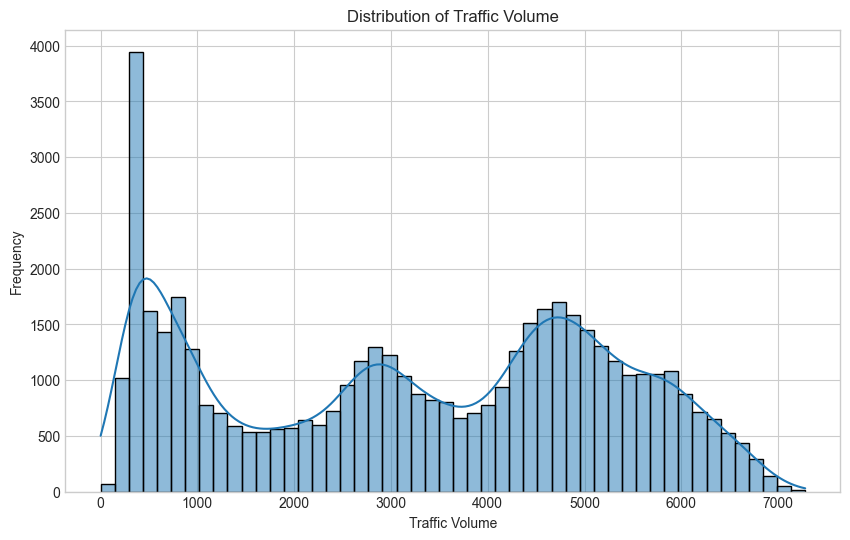

In [5]:
plt.figure(figsize=(10, 6))
sns.histplot(df['traffic_volume'], kde=True, bins=50)
plt.title('Distribution of Traffic Volume')
plt.xlabel('Traffic Volume')
plt.ylabel('Frequency')
plt.show()

**Traffic Volume by Hour and Day of the Week**

C:\Users\hp\AppData\Local\Temp\ipykernel_10828\2952879655.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='hour', y='traffic_volume', hue='day_of_week', palette='viridis', ci=None)


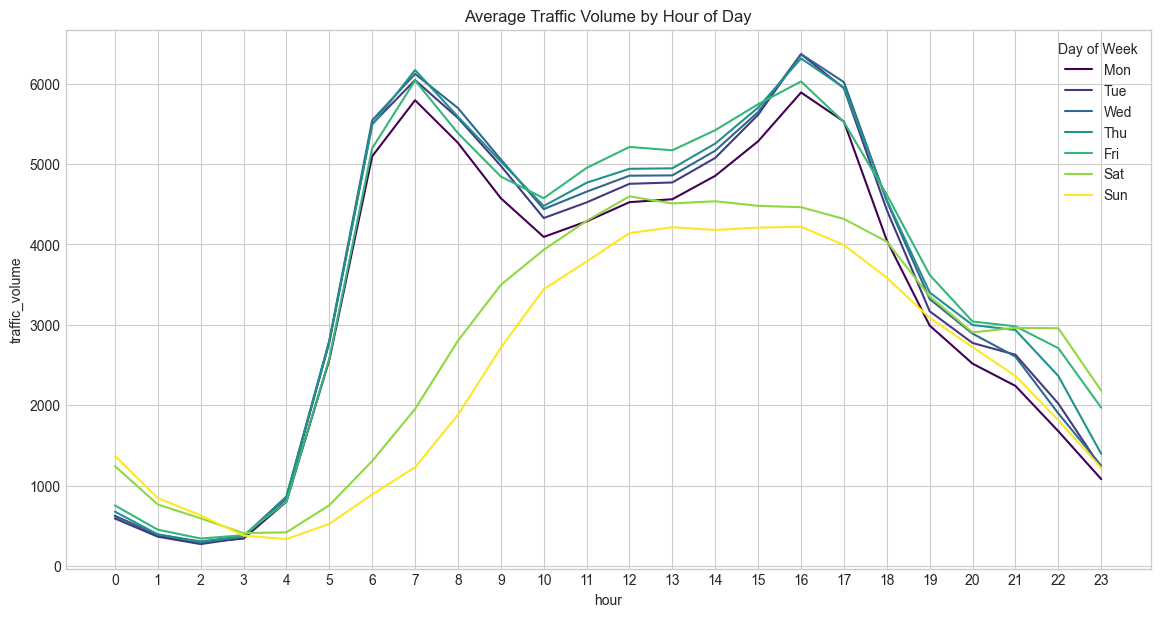

In [6]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='hour', y='traffic_volume', hue='day_of_week', palette='viridis', ci=None)
plt.title('Average Traffic Volume by Hour of Day')
plt.legend(title='Day of Week', labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

#### Correlation Analysis

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()
corr_with_target = correlation_matrix['traffic_volume'].sort_values(ascending=False)

print("Feature Correlation with 'traffic_volume':")
print(corr_with_target)

Feature Correlation with 'traffic_volume':
traffic_volume    1.000000
is_rush_hour      0.454030
hour              0.352401
temp              0.130299
clouds_all        0.067054
year              0.004753
rain_1h           0.004714
snow_1h           0.000733
month            -0.002533
day_of_week      -0.149544
Name: traffic_volume, dtype: float64


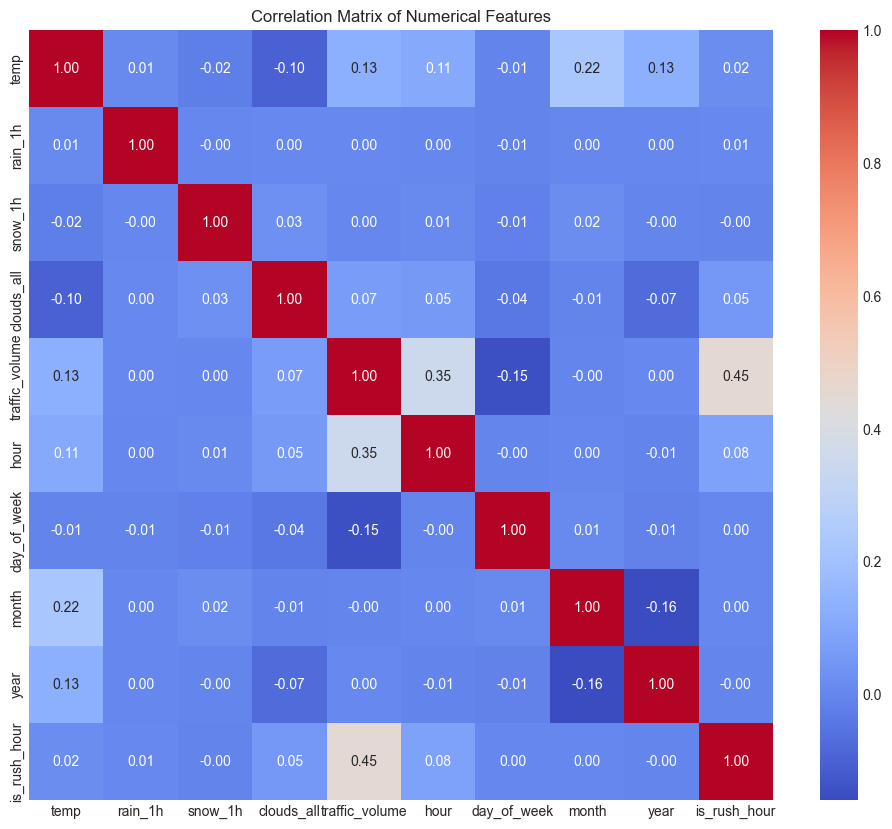

In [8]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

### Step 4: Feature Selection and Preprocessing

In [ ]:
df_model = df.drop(['date_time', 'weather_description', 'year'], axis=1)
X = df_model.drop('traffic_volume', axis=1)
y = df_model['traffic_volume']

In [ ]:
categorical_features = ['holiday', 'weather_main']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

### Step 5: Model Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
model_pipeline.fit(X_train, y_train)

print("Model trained successfully.")

Model trained successfully.


### Step 6: Model Evaluation

In [ ]:
y_pred = model_pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

Model Evaluation:
Root Mean Squared Error (RMSE): 1606.44
R-squared (R2 Score): 0.35


### Step 7: Save the Model Pipeline

In [ ]:
joblib.dump(model_pipeline, 'traffic_model_pipeline.joblib')
print("Model pipeline saved to 'traffic_model_pipeline.joblib'")

Model pipeline saved to 'traffic_model_pipeline.joblib'


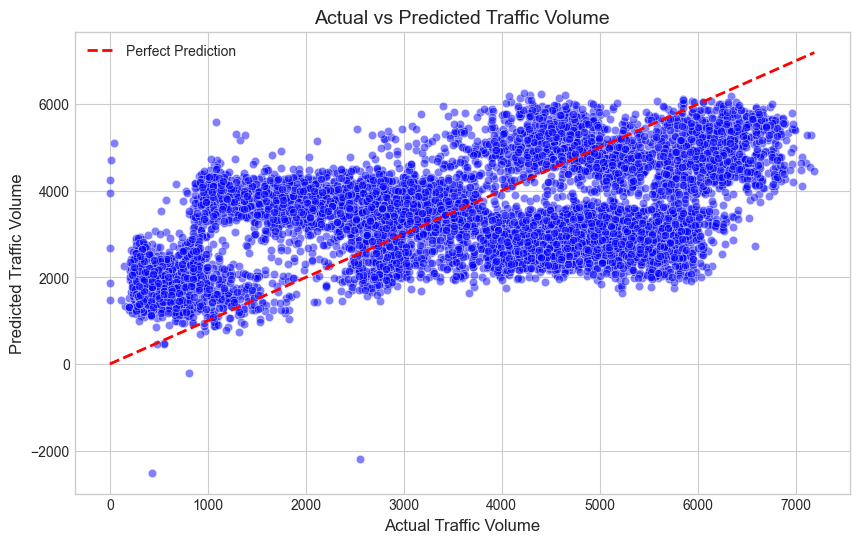

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = model_pipeline.predict(X_test)
results_df = pd.DataFrame({"Actual Traffic Volume": y_test, "Predicted Traffic Volume": y_pred})
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Actual Traffic Volume", y="Predicted Traffic Volume", data=results_df, color="blue", alpha=0.5)
max_val = max(y_test.max(), y_pred.max())
plt.plot([0, max_val], [0, max_val], color="red", linestyle="--", linewidth=2, label="Perfect Prediction")
plt.title("Actual vs Predicted Traffic Volume", fontsize=14)
plt.xlabel("Actual Traffic Volume", fontsize=12)
plt.ylabel("Predicted Traffic Volume", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
